# Project 5 MBTI Label words

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk 
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhengfeichen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zhengfeichen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhengfeichen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Import the data and check / clean the data first

In [2]:
df = pd.read_csv('../data/mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
df.info()
## No need to remove na value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [4]:
df.type.value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

An imbalanced dataset needs process then.

### Process our X (df.posts)

In [5]:
def lemma_sentence(post):
    lemmatizer = WordNetLemmatizer()
    token_words = word_tokenize(post)
    lemmatize_sentence = [lemmatizer.lemmatize(word) for word in token_words] 
    return " ".join(lemmatize_sentence)

def remove_stopwords(post):
    tokens = word_tokenize(post)
    stop = stopwords.words('english')
    filtered_tokens = [word for word in tokens if word.lower() not in stop] 
    return ' '.join(filtered_tokens)

In [6]:
X_stem = df.posts.apply(lemma_sentence)

In [7]:
X_stem = X_stem.apply(remove_stopwords)

In [8]:
X_stem = X_stem.apply(lambda x: x.replace("|||", " "))
X_stem

0       'http : //www.youtube.com/watch ? v=qsXHcwe3kr...
1       ' 'm finding lack post alarming. Sex boring 's...
2       'Good one _____ http : //www.youtube.com/watch...
3       'Dear INTP , enjoyed conversation day . Esoter...
4       'You 're fired. That 's another silly misconce...
                              ...                        
8670    'https : //www.youtube.com/watch ? v=t8edHB_h9...
8671    'So ... thread already exists someplace else (...
8672    'So many question thing . would take purple pi...
8673    ' conflicted right come wanting child . honest...
8674    'It ha long since personalitycafe - although d...
Name: posts, Length: 8675, dtype: object

### Label our y (mbti type)

In [9]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['type'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'ENFJ': 0,
 'ENFP': 1,
 'ENTJ': 2,
 'ENTP': 3,
 'ESFJ': 4,
 'ESFP': 5,
 'ESTJ': 6,
 'ESTP': 7,
 'INFJ': 8,
 'INFP': 9,
 'INTJ': 10,
 'INTP': 11,
 'ISFJ': 12,
 'ISFP': 13,
 'ISTJ': 14,
 'ISTP': 15}

### Train test group split

In [25]:
X_dev, X_test, y_dev, y_test = train_test_split(X_stem, y, test_size=0.2, random_state=42)

In [26]:
pd.Series(y_dev).value_counts()

9     1462
8     1182
11    1011
10     898
1      550
3      550
15     270
13     218
2      187
14     161
0      149
12     121
7       74
5       40
4       35
6       32
Name: count, dtype: int64

### Tf-IDF & Smote

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, 
                                   min_df=3,  
                                   max_features=10000,
                                   ngram_range=(1, 2), 
                                   norm='l2', 
                                   use_idf=True, 
                                   sublinear_tf=True)
X_dev = tfidf_vectorizer.fit_transform(X_dev)
X_test = tfidf_vectorizer.transform(X_test)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_dev, y_dev)

In [28]:
pd.Series(y_smote).value_counts()

8     1462
1     1462
3     1462
9     1462
0     1462
10    1462
2     1462
11    1462
4     1462
13    1462
15    1462
12    1462
6     1462
7     1462
14    1462
5     1462
Name: count, dtype: int64

### Model training

#### Logistic

In [36]:
from sklearn.linear_model import LogisticRegressionCV
logit_model = LogisticRegressionCV(solver='saga', max_iter=1000).fit(X_smote, y_smote)

In [37]:
from sklearn.metrics import classification_report, accuracy_score
y_pred = logit_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6639769452449568
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.32      0.44        41
           1       0.61      0.61      0.61       125
           2       0.62      0.45      0.53        44
           3       0.64      0.61      0.63       135
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       1.00      0.14      0.25         7
           7       0.80      0.27      0.40        15
           8       0.65      0.67      0.66       288
           9       0.69      0.78      0.73       370
          10       0.58      0.70      0.63       193
          11       0.72      0.80      0.75       293
          12       0.95      0.40      0.56        45
          13       0.64      0.47      0.54        53
          14       0.68      0.48      0.56        44
          15       0.66      0.63      0.64        67

    accuracy                

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

#### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_smote, y_smote)
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5936599423631124
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.07      0.12        41
           1       0.66      0.50      0.57       125
           2       0.70      0.32      0.44        44
           3       0.59      0.57      0.58       135
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        15
           8       0.57      0.65      0.61       288
           9       0.54      0.79      0.65       370
          10       0.56      0.60      0.58       193
          11       0.66      0.70      0.68       293
          12       1.00      0.13      0.24        45
          13       0.57      0.25      0.34        53
          14       0.70      0.32      0.44        44
          15       0.81      0.57      0.67        67

    accuracy                

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

#### XGBoost

In [34]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_smote, y_smote)
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6731988472622479
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.22      0.32        41
           1       0.67      0.62      0.65       125
           2       0.59      0.45      0.51        44
           3       0.57      0.63      0.60       135
           4       0.33      0.14      0.20         7
           5       0.00      0.00      0.00         8
           6       1.00      0.14      0.25         7
           7       0.78      0.47      0.58        15
           8       0.67      0.68      0.68       288
           9       0.67      0.81      0.73       370
          10       0.64      0.70      0.67       193
          11       0.73      0.74      0.74       293
          12       0.80      0.53      0.64        45
          13       0.69      0.58      0.63        53
          14       0.79      0.50      0.61        44
          15       0.75      0.63      0.68        67

    accuracy                

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

#### SVM

#### Neural Network

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1_l2

model = Sequential([
    Input(shape=(X_smote.shape[1],)),
    Dense(64, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)),
    BatchNormalization(),  # Add Batch Normalization before the activation
    Activation('relu'),    # Moved the activation to its own layer
    Dropout(0.5),          # Dropout layer for regularization
    
    Dense(64, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)),
    BatchNormalization(),  # Again, Batch Normalization before the activation
    Activation('relu'),    # Moved the activation to its own layer
    Dropout(0.5),         

    Dense(16, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy when labels are integers
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,776 (2.46 MB)

 Trainable params: 645,520 (2.46 MB)

 Non-trainable params: 256 (1.00 KB)

In [31]:
X_train_dense = X_smote.toarray()  # Convert to dense numpy array
X_test_dense = X_test.toarray()

history = model.fit(X_train_dense, y_smote,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test_dense, y_test),
                    verbose=1)

Epoch 1/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3477 - loss: 2.9810 - val_accuracy: 0.4951 - val_loss: 2.5414
Epoch 2/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7532 - loss: 1.6804 - val_accuracy: 0.5833 - val_loss: 2.3978
Epoch 3/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8228 - loss: 1.5821 - val_accuracy: 0.6207 - val_loss: 2.4308
Epoch 4/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8536 - loss: 1.5590 - val_accuracy: 0.6138 - val_loss: 2.5535
Epoch 5/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8730 - loss: 1.5736 - val_accuracy: 0.6277 - val_loss: 2.5478
Epoch 6/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8767 - loss: 1.5741 - val_accuracy: 0.6375 - val_loss: 2.5380
Epoch 7/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8885 - loss: 1.5556 - val_accuracy: 0.6403 - val_loss: 2.5761
Epoch 8/10
731/731 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8900 - loss: 1.5541 - val_accuracy: 0.

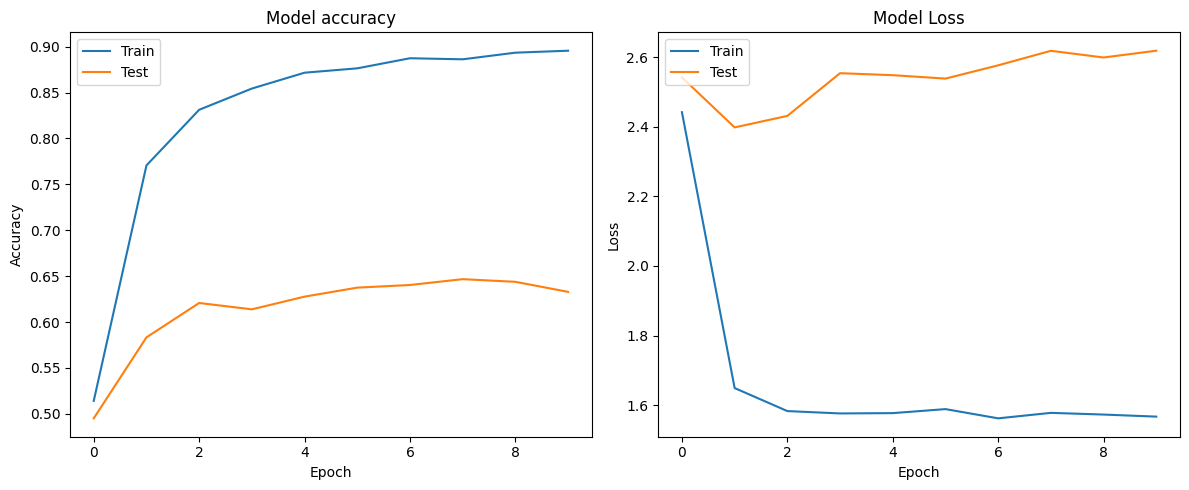

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()